In [1]:
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
import umap.umap_ as umap


import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from transformers import AutoModel, AutoImageProcessor

import clip
from InstructDiffusionWrapper import InstructDiffusion

from attacker_network import AttackerNetwork


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/users/eleves-b/2024/mattia.martino/env_diffusion/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         #std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(root='dogs_data/Images/', transform=transform)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

In [3]:
dino = AutoModel.from_pretrained("facebook/dinov2-small")
dino.to(device)
dino.eval()

clip_model = clip.load("ViT-L/14", device=device)[0]
clip_model.eval()


pix2pix = InstructDiffusion(
    "InstructDiffusion/configs/instruct_diffusion.yaml",
    "InstructDiffusion/checkpoints/v1-5-pruned-emaonly-adaption-task-humanalign.ckpt"
    )

pix2pix.to(device)
pix2pix.eval()

dino_preprocessor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")

[2025-03-16 20:56:34,529] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -lcufile
collect2: error: ld returned 1 exit status


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.53 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from /users/eleves-b/2024/mattia.martino/adversarial-attack-diffusion/InstructDiffusion/checkpoints/v1-5-pruned-emaonly-adaption-task-humanalign.ckpt with 12 missing and 0 unexpected keys
Missing Keys: ['betas', 'alphas_cumprod', 'alphas_cumprod_prev', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'log_one_minus_alphas_cumprod', 'sqrt_recip_alphas_cumprod', 'sqrt_recipm1_alphas_cumprod', 'posterior_variance', 'posterior_log_variance_clipped', 'posterior_mean_coef1', 'posterior_mean_coef2']
Loading model from InstructDiffusion/checkpoints/v1-5-pruned-emaonly-adaption-task-humanalign.ckpt
['betas', 'alphas_cumprod', 'alphas_cumprod_prev', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'log_one_minus_alphas_cu

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
z_test = torch.randn(1, 4, 64, 64, requires_grad=True).to(device)
output_test = pix2pix.model.decode_first_stage(z_test)
output_test.sum().backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [4]:
def compute_centroids(model):
    features = []
    labels = []

    for images, label in tqdm(dataloader):
        images = images.to(device)
        with torch.no_grad():
            feature = model(images).last_hidden_state[:, 0].cpu().numpy()
        features.append(feature)
        labels.extend(label.cpu().numpy())
    
    features = np.concatenate(features, axis=0)
    labels = np.array(labels)

    unique_classes = np.unique(labels)
    n_classes = len(unique_classes)

    centroids = np.zeros((n_classes, features.shape[1]))
    for i, c in enumerate(unique_classes):
        class_indices = np.where(labels == c)[0]
        centroids[i] = np.mean(features[class_indices], axis=0)

    os.makedirs("variables", exist_ok=True)
    np.save('variables/centroids.npy', centroids)
    np.save('variables/features.npy', features)
    np.save('variables/labels.npy', labels)

    return centroids, features, labels

In [5]:
# centroids, features, labels = compute_centroids(dino)

centroids = np.load('variables/centroids.npy')
features = np.load('variables/features.npy')
labels = np.load('variables/labels.npy')

In [6]:
np.random.seed(0)

unique_classes = np.unique(labels)
n_classes = len(unique_classes)

class_id_to_name = {v: k for k, v in dataset.class_to_idx.items()}
class_names = [class_id_to_name[cls] for cls in unique_classes]

random_classes = np.random.choice(unique_classes, size=2, replace=False)
starting_class = random_classes[0]
starting_class_name = class_id_to_name[starting_class].split('-')[-1]
target_class = random_classes[1]
target_class_name = class_id_to_name[target_class].split('-')[-1]

classes = {starting_class: starting_class_name + " (starting)", target_class: target_class_name + " (target)"}

print(f"Starting class: {starting_class_name} ({starting_class})")
print(f"Target class: {target_class_name} ({target_class})")

Starting class: Bedlington_terrier (26)
Target class: English_springer (61)


/users/eleves-b/2024/mattia.martino/env_diffusion/lib64/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


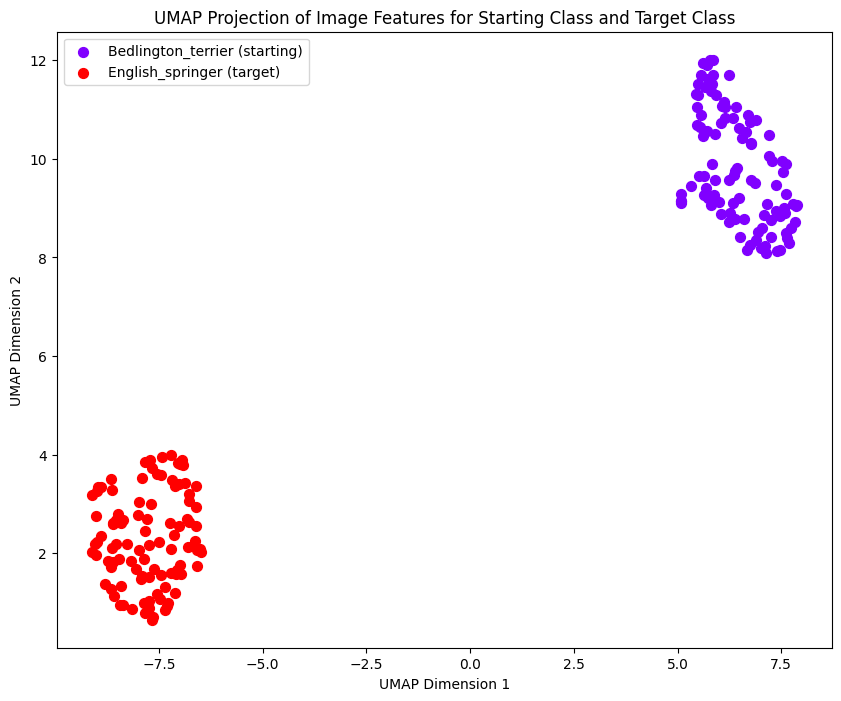

In [7]:
np.random.seed(0)

subset_size = 100

starting_features = []
target_features = []
for c in random_classes:
    class_indices = np.where(labels == c)[0]
    sampled_indices = np.random.choice(class_indices, size=subset_size, replace=False)
    if c == starting_class:
        starting_features.append(features[sampled_indices])
    else:
        target_features.append(features[sampled_indices])

starting_features = np.concatenate(starting_features, axis=0)
target_features = np.concatenate(target_features, axis=0)

starting_labels = np.full((starting_features.shape[0],), starting_class)
target_labels = np.full((target_features.shape[0],), target_class)

plotting_features = np.concatenate([starting_features, target_features], axis=0)
plotting_labels = np.concatenate([starting_labels, target_labels], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=0)
embedding = umap_reducer.fit_transform(plotting_features)

colors = cm.rainbow(np.linspace(0, 1, len(random_classes)))

plt.figure(figsize=(10, 8))
# Plot features for each selected class with a distinct color
for i, cls in enumerate(random_classes):
    cls_mask = (plotting_labels == cls)
    plt.scatter(
        embedding[cls_mask, 0],
        embedding[cls_mask, 1],
        s=50,
        color=colors[i],
        label=classes[cls]
    )

plt.title("UMAP Projection of Image Features for Starting Class and Target Class")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.show()

In [8]:
starting_centroid = centroids[starting_class]
target_centroid = centroids[target_class]
starting_centroid = starting_centroid / np.linalg.norm(starting_centroid)
target_centroid = target_centroid / np.linalg.norm(target_centroid)

# Compute the distance between the centroids
distance = cosine_distances(starting_centroid.reshape(1, -1), target_centroid.reshape(1, -1))[0][0]
print(f"Cosine distance between centroids: {distance:.2f}")

distances = cosine_distances(centroids)
average_distance = distances.mean()
print(f"Average cosine distance between centroids: {average_distance:.2f}")

min_distance = distances[~np.eye(distances.shape[0], dtype=bool)].min()
print(f"Minimum cosine distance between centroids: {min_distance:.2f}")

max_distance = distances[~np.eye(distances.shape[0], dtype=bool)].max()
print(f"Maximum cosine distance between centroids: {max_distance:.2f}")

Cosine distance between centroids: 0.82
Average cosine distance between centroids: 0.77
Minimum cosine distance between centroids: 0.04
Maximum cosine distance between centroids: 1.20


In [9]:
# target_indices = [i for i, (_, label) in enumerate(dataset) if label == starting_class]
# target_indices = np.save('variables/target_indices.npy', target_indices)
target_indices = np.load('variables/target_indices.npy')
breed_subset = Subset(dataset, target_indices)

pil_to_tensor = transforms.ToTensor() 
tensor_to_pil = transforms.ToPILImage()

In [10]:
np.random.seed(0)

attacker = AttackerNetwork(
    device=device,
    pix2pix_model=pix2pix,
    dinov2_model=dino,
    clip_model=clip_model,
    
)
attacker.train()

n_epochs = 1

optimizer = torch.optim.Adam(attacker.parameters(), lr=1e-3)

target_centroid = torch.tensor(target_centroid).to(device).unsqueeze(0)
target_centroid = F.normalize(target_centroid, dim=1)


In [11]:
image = breed_subset[0][0]

In [12]:
image = image.unsqueeze(0).to(device)

output, modified_image = attacker(image)

True
True
True
False
False


In [13]:
output = F.normalize(output, dim=1)

cosine_sim = F.cosine_similarity(output.squeeze(0), target_centroid, dim=1)
cosine_dist = 1 - cosine_sim

loss = cosine_dist.mean()


In [14]:
attacker.positive_prompt()

tensor([[[-0.3884,  0.0229, -0.0523,  ..., -0.4900, -0.3066,  0.0674],
         [ 0.0517, -0.6050,  1.9248,  ..., -0.3979,  0.9658, -0.4429],
         [ 0.5977, -0.2202,  1.4980,  ..., -1.5723,  0.4390,  0.8198],
         ...,
         [ 0.2098, -1.8516, -0.3704,  ..., -1.1631,  0.6650, -0.8320],
         [ 0.4165, -1.8555, -0.3025,  ..., -1.1016,  0.6265, -0.7505],
         [ 1.3711, -1.0928,  0.4443,  ..., -1.0908, -0.0663, -0.5669]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<ToCopyBackward0>)

In [15]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f"Loss: {loss.item():.4f}")

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
for epoch in range(n_epochs):
    for image, _ in tqdm(breed_subset, desc=f"Epoch {epoch+1}/{n_epochs}"):
        image = image.to(device)

        output, _, _ = attacker(image)
        output_norm = F.normalize(output, dim=1)


        cosine_sim = F.cosine_similarity(output_norm, target_centroid, dim=1)
        cosine_dist = 1 - cosine_sim

        loss = cosine_dist.mean()
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item():.4f}")
